<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/5/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [2]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, extract, split, check data distribution**

In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download  -c dogs-vs-cats -p /content/kaggle/dogscats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 81.9MB/s]
 99% 537M/543M [00:15<00:00, 23.3MB/s]
100% 543M/543M [00:15<00:00, 36.0MB/s]
 97% 263M/271M [00:04<00:00, 65.7MB/s]
100% 271M/271M [00:04<00:00, 57.1MB/s]


Extract .zip


In [0]:
!unzip kaggle/dogscats/train.zip -d train
!unzip kaggle/dogscats/test1.zip -d test

In [5]:
%ls

adc.json  kaggle/  sample_data/  test/  train/


In [6]:
import pandas as pd
import os

TRAIN_PATH = './train/train'
TEST_PATH = './test/test1'

filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,category
0,cat.2910.jpg,cat
1,cat.3176.jpg,cat
2,cat.6647.jpg,cat
3,dog.1106.jpg,dog
4,cat.6265.jpg,cat


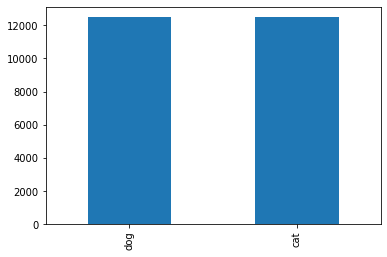

In [0]:
df['category'].value_counts().plot.bar()

Train/Dev split


In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.20, random_state=42)

Check data distribution

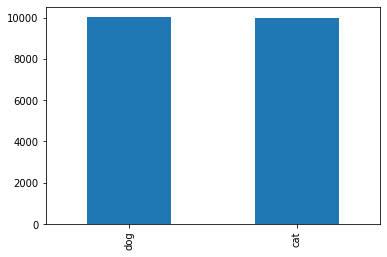

In [0]:
train['category'].value_counts().plot.bar()

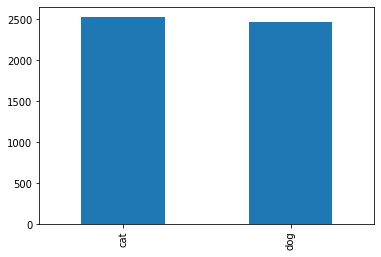

In [0]:
val['category'].value_counts().plot.bar()

Use `ImageDataGenerator` in order to reduce data memory consumption (just with rescaling for improving speed of learning)

In [9]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# train
train_datagen = ImageDataGenerator(rescale=1./255)

total_train = train.shape[0]
total_validate = val.shape[0]
batch_size = 32  # since Andrew Ng told, that better use 2^n

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

train_generator = train_datagen.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# TODO: implement test set preparation 

# **Part 2: DNN architecture**

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 classes: dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        25

In [11]:
history = model.fit_generator(
    train_generator, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
625/625 [==============================] - 74s 118ms/step - loss: 0.7093 - acc: 0.6717 - val_loss: 0.5103 - val_acc: 0.7496
Epoch 2/30
625/625 [==============================] - 66s 105ms/step - loss: 0.4665 - acc: 0.7805 - val_loss: 0.6416 - val_acc: 0.7341
Epoch 3/30
625/625 [==============================] - 65s 104ms/step - loss: 0.3966 - acc: 0.8262 - val_loss: 0.3763 - val_acc: 0.8353
Epoch 4/30
625/625 [==============================] - 65s 104ms/step - loss: 0.3345 - acc: 0.8579 - val_loss: 0.4270 - val_acc: 0.8072
Epoch 5/30
625/625 [==============================] - 68s 109ms/step - loss: 0.2936 - acc: 0.8756 - val_loss: 0.4239 - val_acc: 0.8152
Epoch 6/30
625/625 [==============================] - 72s 116ms/step - loss: 0.2611 - acc: 0.8909 - val_loss: 0.4299 - val_acc: 0.8156
Epoch 7/30
625/625 [==============================] - 72s 115ms/step - loss: 0.2280 - acc: 0.9

# **Part 3: Add data augmentation**

In [12]:
train_datagen_aug = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


And train NN again

In [13]:
history = model.fit_generator(
    train_generator_aug, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
625/625 [==============================] - 134s 214ms/step - loss: 0.5200 - acc: 0.8266 - val_loss: 0.3236 - val_acc: 0.8718
Epoch 2/30
625/625 [==============================] - 131s 209ms/step - loss: 0.3631 - acc: 0.8474 - val_loss: 0.2926 - val_acc: 0.8804
Epoch 3/30
625/625 [==============================] - 130s 209ms/step - loss: 0.3352 - acc: 0.8573 - val_loss: 0.4228 - val_acc: 0.8434
Epoch 4/30
625/625 [==============================] - 132s 211ms/step - loss: 0.3273 - acc: 0.8595 - val_loss: 0.9596 - val_acc: 0.7651
Epoch 5/30
625/625 [==============================] - 132s 211ms/step - loss: 0.3155 - acc: 0.8661 - val_loss: 0.3775 - val_acc: 0.8484
Epoch 6/30
625/625 [==============================] - 132s 211ms/step - loss: 0.3043 - acc: 0.8717 - val_loss: 0.3074 - val_acc: 0.8776
Epoch 7/30
625/625 [==============================] - 136s 218ms/step - loss: 0.2946 - acc: 0.8777 - val_loss: 0.3392 - val_acc: 0.8706
Epoch 8/30
625/625 [============================

# **Part 4: using VGG16**



Define model

In [0]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

# load model
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in vgg.layers:
	layer.trainable = False

# define a new output layer to connect with the last fc layer in vgg
x = Flatten()(vgg.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
bn = BatchNormalization()(class1)
do = Dropout(0.5)(bn)
output_layer = Dense(2, activation='softmax', name='predictions')(do)

# combine the original VGG model with the new output layer
vgg = Model(inputs=vgg.input, outputs=output_layer)

vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit_generator(
    train_generator_aug, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/30
625/625 [==============================] - 133s 213ms/step - loss: 0.3228 - acc: 0.8816 - val_loss: 0.2928 - val_acc: 0.8718
Epoch 2/30
625/625 [==============================] - 131s 210ms/step - loss: 0.2766 - acc: 0.8890 - val_loss: 0.2544 - val_acc: 0.9004
Epoch 3/30
625/625 [==============================] - 131s 209ms/step - loss: 0.2596 - acc: 0.8937 - val_loss: 0.2163 - val_acc: 0.9163
Epoch 4/30
625/625 [==============================] - 129s 207ms/step - loss: 0.2578 - acc: 0.8943 - val_loss: 0.2192 - val_acc: 0.9193
Epoch 5/30
625/625 [==============================] - 130s 208ms/step - loss: 0.2440 - acc: 0.9004 - val_loss: 0.2389 - val_acc: 0.9175
Epoch 6/30
625/625 [==============================] - 130s 208ms/step - loss: 0.2401 - acc: 0.9024 - val_loss: 0.2254 - val_acc: 0.9171
Epoch 7/30
625/625 [==============================] - 131s 209ms/step - loss: 0.2475 - acc: 0.8982 - val_loss: 0.2491 - val_acc: 0.9209
Epoch 8/30
625/625 [============================